# (Basic) Cross-Validation

The main topic of this demo is cross-validation but I'd also like to talk about the train-test split.

In [35]:
import pandas as pd
from matplotlib import pyplot as plt

This is the original California Housing dataset before any data cleaning and feature engineering or scaling. Let's see how we would do these two things properly.

In [2]:
data = pd.read_csv("cali_housing.csv")
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
data.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
data.duplicated().sum()

np.int64(0)

The dataset is already fairly clean. I'm just going to encode the categorical column `ocean_proximity` and drop the outliers in `median_house_value`.

In [6]:
data = pd.get_dummies(data, columns=["ocean_proximity"], drop_first=True)
# Drop rows of data where `median_house_value` is greater than 500000
data = data[data["median_house_value"] <= 500000]
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,False,False,True,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,False,False,True,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,False,False,True,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,False,False,True,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,False,False,True,False


As for data prep, we just need to take care of those 207 rows missing `total_bedrooms`. If we were dropping those rows or the `total_bedrooms` feature altogether, we could go ahead and do that right now. But I'd like to *impute* those missing values with the mean or median. Here's the problem: that would inject information about the entire dataset into those missing rows, which would create data leakage if we carved out the test set afterwards. That's why such techniques should always be applied after the split. The same reasoning goes for feature scaling.  
So let's talk about the train-test split first.  
Now before splitting the data, we need to specify what columns are features and what is a target. I'm going to use X for our matrix of features and y for the target.

In [7]:
# Define target and features
X = data.drop(["median_house_value"], axis=1)
y = data["median_house_value"]

Now we can split the data. Let's say we want to use 20% of the whole dataset for testing. This is also where we can have scikit-learn shuffle the dataset for us, which is good practice in general machine learning, but not advised for temporal data which is what we usually deal with in models for trading. But here our data does not have a time dimension so I'm going to shuffle the data.

In [8]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=52)

Rememeber the dataset had around 21,000 rows. Let's see if the split worked as expected:

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15740, 12), (3935, 12), (15740,), (3935,))

Yep, those numbers make sense. Let's take a look at how those missing rows are spread between training and test sets now...

In [10]:
X_train["total_bedrooms"].isna().sum(), X_test["total_bedrooms"].isna().sum()

(np.int64(162), np.int64(38))

This is why we didn't impute before the split.  
*Now* we can impute missing rows and this is how we do that correctly:

In [11]:
# Impute missing values in training and testing sets for the columns with missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

Note that I applied `fit_transform()` to X_train and only `transform()` to X_test. This means I'm fitting, that is calculating the median, from the training set only, and then injecting that into missing values in both the training and test sets.  
See if we had done this before the split, the median would have been:

In [12]:
X["total_bedrooms"].median()

np.float64(436.0)

But because it's calculated over `X_train` only, this is the value that'll be used to fill missing `total_bedrooms`:

In [13]:
imputer.statistics_[4]

np.float64(435.0)

Feature scaling should also be done in this same manner: Fit to the training set, transform both sets with the fitted scaler.  

In [14]:
# Standardize the training and testing data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_imputed_scaled = scaler.fit_transform(X_train_imputed)
X_test_imputed_scaled = scaler.transform(X_test_imputed)


Let's take a look at the result:

In [15]:
X_train_imputed_scaled

array([[ 0.25568292,  0.1471285 , -0.82875982, ..., -0.01380701,
        -0.3446328 , -0.37681097],
       [ 0.97427309, -0.8945114 ,  0.60417032, ..., -0.01380701,
        -0.3446328 , -0.37681097],
       [-0.08365132, -0.56434875,  0.36534863, ..., -0.01380701,
        -0.3446328 , -0.37681097],
       ...,
       [ 0.61497801, -0.72710498,  1.40024262, ..., -0.01380701,
        -0.3446328 , -0.37681097],
       [ 0.73474303, -0.86661033,  0.12652694, ..., -0.01380701,
        -0.3446328 , -0.37681097],
       [ 0.94932204, -0.92706264, -1.06758151, ..., -0.01380701,
        -0.3446328 , -0.37681097]])

One slight inconvenience is that these scikit-learn functions convert Pandas DataFrames to Numpy arrays, which gets rid of the column names. They do this because numpy arrrays are much more efficient for model training and besides the extra metadata like column names are not needed for ML. But fortunately the order of data is preserved, so we can just re-cast the data as a DataFrame and stick the column names back on.  
You'll also notice that the boolean values for our one-hot-encoded columns have been changed to zeros and ones, which is absolutely fine. Those are equivalent.

In [20]:
X_train = pd.DataFrame(X_train_imputed_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_imputed_scaled, columns=X_test.columns)
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.255683,0.147129,-0.828760,-0.646014,-0.543102,-0.085303,-0.579551,-1.149582,1.417590,-0.013807,-0.344633,-0.376811
1,0.974273,-0.894511,0.604170,-0.587513,-0.731338,-0.784634,-0.742218,1.244613,-0.705423,-0.013807,-0.344633,-0.376811
2,-0.083651,-0.564349,0.365349,-0.717565,-0.380750,-0.593438,-0.375572,-0.850021,-0.705423,-0.013807,-0.344633,-0.376811
3,0.689831,-0.829409,1.241028,-0.414710,-0.336044,-0.302337,-0.303276,-0.417237,-0.705423,-0.013807,-0.344633,-0.376811
4,0.749714,-0.796858,0.206134,-0.777866,-0.790161,-0.481476,-0.804186,-0.001966,-0.705423,-0.013807,-0.344633,-0.376811


In [21]:
X_train["total_bedrooms"].isna().sum(), X_test["total_bedrooms"].isna().sum()

(np.int64(0), np.int64(0))

Let's now shift our focus to the main topic of this demo which is validation and cross validation.  

Validation sets are carved out of the training set. We could use the same `train_test_split()` function to carve out a single validation set, which is common practice in NNs/DL, because we can't afford to train and validate multiple times. But for classic ML we _can_! So let's take a look at the most common of these: k-fold CV.

In [28]:
# train a linear regression model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
from sklearn.metrics import r2_score
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

0.6089233274539658

Okay, so we got an R-squared score of 60% with a simple linear regression model. But what was the training score?

In [29]:
model.score(X_train, y_train)

0.6125719255669393

62% is not far off from the 60% we got with the test set. But this is an extremely simple example and in more complex, real-world problems, there could be a much wider gap. Which is why we use k-fold cross-validation to get a more reliable estimate of what the test score might be. Let's see how the model would have done on 5-fold CV:

In [32]:
from sklearn.model_selection import cross_val_score


r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="r2")
r2_scores

array([0.61117885, 0.62704765, 0.60252854, 0.56943955, 0.63743161])

In [33]:
r2_scores.mean()

np.float64(0.6095252391119483)

We can see this is already much closer to what we actually got with the test set. That's because this score was obtained by training a model on 5 different subsets of the training data and evaluating it on a different validation set each time.

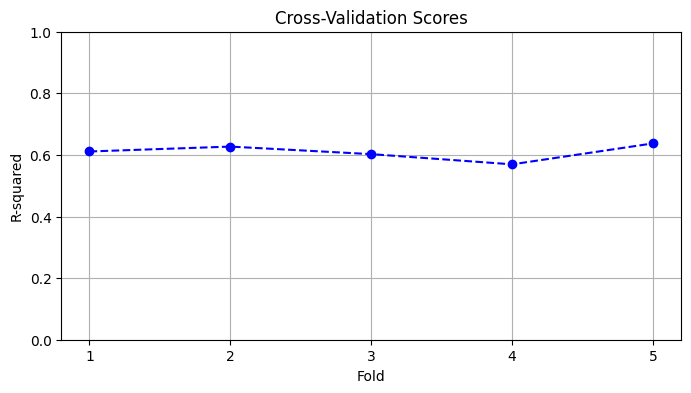

In [40]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, 6), r2_scores, marker='o', linestyle='--', color='b')
plt.title('Cross-Validation Scores')
plt.xticks(ticks=range(1, 6), labels=range(1, 6))
plt.xlabel('Fold')
plt.ylabel('R-squared')
plt.ylim([0, 1])
plt.grid(True)
plt.show()